In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


train_df = pd.read_csv('train.csv')

In [5]:
def filter_data(data, train = True, preprocessor=None):
    training_data = data.copy()
    training_data['NameLength'] = training_data['Name'].str.len()
    training_data[['Deck', 'Num', 'Side']] = training_data['Cabin'].str.split('/', expand=True)
    training_data = training_data.drop(columns=['PassengerId', 'Name', 'Cabin'])

    target = None
    if train:
        target = training_data['Transported']
        training_data = training_data.drop(columns=['Transported'])

    features  = training_data.columns.tolist()
    categorical_features = ['HomePlanet', 'Destination', 'Side', 'Deck']
    numeric_features = [col for col in features if col not in categorical_features]

    for col in ['CryoSleep', 'VIP']:
        training_data[col] = training_data[col].fillna(False).astype(int)

    training_data['Num'] = pd.to_numeric(training_data['Num'], errors='coerce')



    if preprocessor is None:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        X_processed = preprocessor.fit_transform(training_data)

    else:
        # Use passed preprocessor to transform (inference mode)
        X_processed = preprocessor.transform(training_data)

    if train:
        return X_processed, target, preprocessor
    else:
        return X_processed

In [22]:
def filter_data2(data, train = True, preprocessor=None):
    training_data = data.copy()
    training_data['NameLength'] = training_data['Name'].str.len()
    training_data[['Deck', 'Num', 'Side']] = training_data['Cabin'].str.split('/', expand=True)
#RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
    training_data['total spending'] = training_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)
    spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_categories:
        training_data[col] = (training_data[col]/training_data['total spending']).fillna(0)

    training_data['Num'] = training_data['Num'].astype(str).str.strip()

    training_data = training_data.drop(columns=['PassengerId', 'Name', 'Cabin'])

    target = None
    if train:
        target = training_data['Transported']
        training_data = training_data.drop(columns=['Transported'])

    features  = training_data.columns.tolist()

    categorical_features = ['HomePlanet', 'Destination', 'Side', 'Deck', 'Num']
    numeric_features = [col for col in features if col not in categorical_features]
    for col in ['CryoSleep', 'VIP']:
        training_data[col] = training_data[col].fillna(False).astype(int)


    if preprocessor is None:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        X_processed = preprocessor.fit_transform(training_data)

    else:
        # Use passed preprocessor to transform (inference mode)
        X_processed = preprocessor.transform(training_data)

    if train:
        return X_processed, target, preprocessor
    else:
        return X_processed

In [110]:
def filter_data3(data, train = True, preprocessor=None):
    training_data = data.copy()
    training_data['NameLength'] = training_data['Name'].str.len()
    training_data[['Deck', 'Num', 'Side']] = training_data['Cabin'].str.split('/', expand=True)
#RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
    training_data['total spending'] = training_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)
    maxspending = training_data['total spending'].max()
    training_data['portional_spend'] = training_data['total spending'] / maxspending
    spending_categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_categories:
        training_data[col] = (training_data[col]/training_data['total spending']).fillna(0)

    training_data['Num'] = training_data['Num'].astype(str).str.strip()
    training_data['Num'] = pd.to_numeric(training_data['Num'], errors='coerce')
    training_data['NumBin'] = pd.qcut(training_data['Num'], q=7, duplicates='drop').astype(str)


    home_planet_map = {'Earth': 0, 'Europa': 1, 'Mars': 2}
    destination_map = {'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2}

    training_data['HomePlanet'] = training_data['HomePlanet'].map(home_planet_map)
    training_data['Destination'] = training_data['Destination'].map(destination_map)

    training_data = training_data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Num', 'VIP'])

    target = None
    if train:
        target = training_data['Transported']
        training_data = training_data.drop(columns=['Transported'])

    training_data['combination'] = training_data['Deck'] + training_data['Side']+training_data['NumBin']



    categorical_features = ['Side', 'Deck', 'NumBin', 'combination']
    features  = training_data.columns.tolist()

    numeric_features = [col for col in features if col not in categorical_features]
    for col in ['CryoSleep']:
        training_data[col] = training_data[col].fillna(False).astype(int)




    categorical_features = ['combination']
    training_data = training_data.drop(columns=['Side', 'Deck', 'NumBin'])




    if preprocessor is None:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        X_processed = preprocessor.fit_transform(training_data)

    else:
        # Use passed preprocessor to transform (inference mode)
        X_processed = preprocessor.transform(training_data)

    if train:
        return X_processed, target, preprocessor
    else:
        return X_processed

In [7]:
def test(y_pred, y_test):
    y_pred = np.array(y_pred)

    # ✅ If shape is (n_samples, 1), flatten it to (n_samples,)
    if y_pred.ndim > 1:
        y_pred = y_pred.ravel()

    # ✅ Only threshold if values are probabilities (i.e. float)
    if y_pred.dtype != int and y_pred.dtype != np.int64:
        y_pred = (y_pred >= 0.5).astype(int)

    np_y_test = np.array(y_test)
    print(np.unique(np_y_test), np_y_test.dtype)
    print(np.unique(y_pred), y_pred.dtype)


    acc = accuracy_score(np_y_test, y_pred)
    prec = precision_score(np_y_test, y_pred)
    rec = recall_score(np_y_test, y_pred)
    f1 = f1_score(np_y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(np_y_test, y_pred))

In [111]:
processed_data, target, preprocessor = filter_data3(train_df, train=True)

X_train, X_test, y_train, y_test = train_test_split(processed_data, target, test_size=0.1, random_state=42, shuffle=False)
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test(y_pred, y_test)

[False  True] bool
[0 1] int64

Accuracy: 0.7989
Precision: 0.7824
Recall: 0.7882
F1 Score: 0.7853
Confusion Matrix:
 [[375  89]
 [ 86 320]]


                               Feature  Importance
11                num__portional_spend    0.231396
10                 num__total spending    0.164512
5                       num__FoodCourt    0.152051
6                    num__ShoppingMall    0.119417
0                      num__HomePlanet    0.067087
1                       num__CryoSleep    0.053113
76  cat__combination_GS(913.0, 1284.0]    0.023454
8                          num__VRDeck    0.022045
7                             num__Spa    0.021339
3                             num__Age    0.020971
4                     num__RoomService    0.017392
74   cat__combination_GS(556.0, 913.0]    0.010690
41   cat__combination_EP(309.0, 556.0]    0.009287
32    cat__combination_CS(91.0, 193.0]    0.008400
9                      num__NameLength    0.008157
2                     num__Destination    0.008078
62  cat__combination_FS(913.0, 1284.0]    0.008030
14                  num__CryoSleep_len    0.006202
60   cat__combination_FS(556.0,

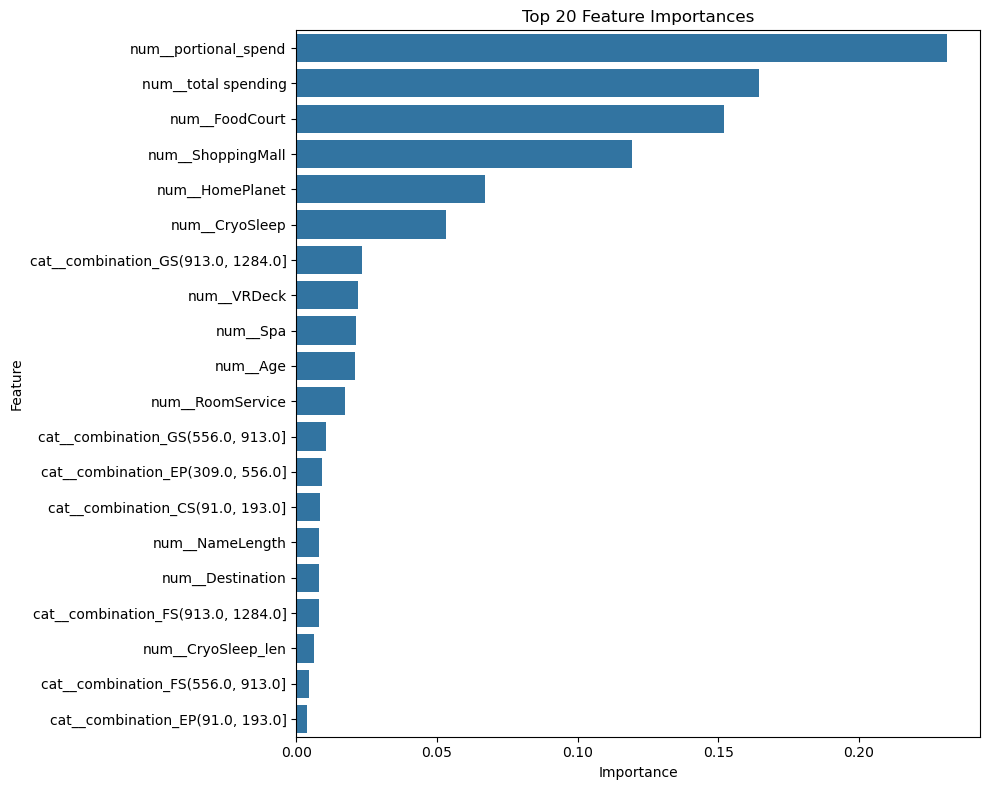

In [103]:
import seaborn as sns

importances = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False).head(20)
print(feature_df)
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_df)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()